In [162]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.plot import add_changepoints_to_plot
from sklearn.metrics import mean_squared_error, r2_score

In [203]:
def TSProphet(com, com_fut, pred_list=['EHGDUSY Index', 'CPI Change', 'RR2YCUS Index']):
    df = pd.DataFrame()
    df['ds'] = spot['DATE']
    df['y'] = spot[com].values
    model = Prophet()
    for p in pred_list:
        df[p] = predictors[p].values
        model.add_regressor(p)
    df[com_fut] = futures[com_fut].values
    model.add_regressor(com_fut)
    test_pd = 12
    train = df[:-test_pd]
    model.fit(train)
#     model.fit(df)
#     forecast = model.predict(df)

#     cutoffs = pd.to_datetime(['2012-06-01', '2012-12-01', '2013-06-01', '2013-12-01', '2014-06-01','2014-12-01', '2015-06-01', '2015-12-01', 
#                               '2016-06-01', '2016-12-01', '2017-06-01', '2017-12-01', '2018-06-01','2018-12-01', '2019-06-01', '2019-12-01',
#                               '2020-06-01', '2020-12-01', '2021-06-01'])
#     df_cv = cross_validation(model, cutoffs=cutoffs, horizon = '365 days')
#     df_p = performance_metrics(df_cv)
#     print(df_p)
    


    future = model.make_future_dataframe(periods=test_pd, freq='MS')
    for p in pred_list:
        future[p] = df[p].values
    future[com_fut] = futures[com_fut].values
    forecast = model.predict(future)
    forecast['actual'] = df['y'].values
    trainMSE = mean_squared_error(forecast['actual'][:-test_pd], forecast['yhat'][:-test_pd], squared=False)
    testMSE = mean_squared_error(forecast['actual'][-test_pd:], forecast['yhat'][-test_pd:], squared=False)
    trainR2 = r2_score(forecast['actual'][:-test_pd], forecast['yhat'][:-test_pd])
    testR2 = r2_score(forecast['actual'][-test_pd:], forecast['yhat'][-test_pd:])
    print(f"Train RMSE: {trainMSE}")
    print(f"Test RMSE: {testMSE}")
    print(f"Train R2: {trainR2}")
    print(f"Test R2: {testR2}")
    
    fig = model.plot(forecast)
    a = add_changepoints_to_plot(fig.gca(), model, forecast)
#     sns.lineplot(x=forecast['ds'], y=forecast['yhat'])
    plt.axvline(pd.Timestamp('2021-08-01'), color='black', ls=':')

    sns.scatterplot(x=forecast['ds'], y=forecast['actual'], color='black', s=15)
    model.plot_components(forecast)

    return forecast
    

### Predictions on SPOT CHANGE

In [178]:
predictors = pd.read_excel('./predictors_monthly.xlsx')
commodity = pd.read_excel('../Processed data files/data_master.xlsx', header=1, sheet_name="Monthly Data")

In [180]:
for col in commodity.columns:
    commodity.rename(columns={col: col.replace(u'\xa0', u' ') }, inplace=True)
    if col[-1] == ' ':
        commodity.rename(columns={col: col[:-1] }, inplace=True)

In [181]:
spot = commodity[['DATE', 'Agriculture Spot', 'Energy Spot','Industrial Metals Spot', 'Livestock Spot', 'Precious Metals Spot']]
futures = commodity[['DATE', 'Agriculture', 'Energy', 'Industrial Metals', 'Livestock', 'Precious Metals']]

In [182]:
spot

,DATE,Agriculture Spot,Energy Spot,Industrial Metals Spot,Livestock Spot,Precious Metals Spot
0,2001-12-31,NaN,NaN,NaN,NaN,NaN
1,2002-01-31,-0.009199,-0.036421,0.057489,0.068000,-0.012196
2,2002-02-28,0.005970,0.129610,0.002939,-0.014070,0.055256
3,2002-03-28,0.057970,0.244007,0.038503,-0.065744,0.024125
4,2002-04-30,-0.036229,0.060749,-0.008081,-0.079988,0.007877
...,...,...,...,...,...,...
244,2022-04-29,0.049304,0.127528,-0.062512,-0.068244,-0.036434
245,2022-05-31,-0.020143,0.096899,-0.065328,-0.004368,-0.039567
246,2022-06-30,-0.133687,-0.167460,-0.158537,-0.011867,-0.031306
247,2022-07-29,-0.022205,0.108397,0.014548,0.026434,-0.012660


In [183]:
predictors['CPI Change'] = predictors['CPURNSA Index'].diff()
predictors = predictors[12:]
spot = spot[1:]
futures = futures[1:]

In [184]:
predictors['date'] = predictors['date'].dt.to_period('M')
spot['date'] = spot['DATE'].dt.to_period('M')
futures['date'] = futures['DATE'].dt.to_period('M')

C:\Users\Arushi Jain\AppData\Local\Temp\ipykernel_5044\2615701425.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spot['date'] = spot['DATE'].dt.to_period('M')


In [185]:
spot

,DATE,Agriculture Spot,Energy Spot,Industrial Metals Spot,Livestock Spot,Precious Metals Spot,date
1,2002-01-31,-0.009199,-0.036421,0.057489,0.068000,-0.012196,2002-01
2,2002-02-28,0.005970,0.129610,0.002939,-0.014070,0.055256,2002-02
3,2002-03-28,0.057970,0.244007,0.038503,-0.065744,0.024125,2002-03
4,2002-04-30,-0.036229,0.060749,-0.008081,-0.079988,0.007877,2002-04
5,2002-05-31,0.075086,-0.097541,0.001833,-0.058547,0.071502,2002-05
...,...,...,...,...,...,...,...
244,2022-04-29,0.049304,0.127528,-0.062512,-0.068244,-0.036434,2022-04
245,2022-05-31,-0.020143,0.096899,-0.065328,-0.004368,-0.039567,2022-05
246,2022-06-30,-0.133687,-0.167460,-0.158537,-0.011867,-0.031306,2022-06
247,2022-07-29,-0.022205,0.108397,0.014548,0.026434,-0.012660,2022-07


In [149]:
# spot['DATE'] = pd.to_datetime(spot['DATE'])
# futures['DATE'] = pd.to_datetime(futures['DATE'])
# predictors['DATE'] = pd.to_datetime(predictors['DATE'])
# spot.set_index('DATE', inplace=True)
# futures.set_index('DATE', inplace=True)
# predictors.set_index('date', inplace=True)

Text(0, 0.5, 'Spot')

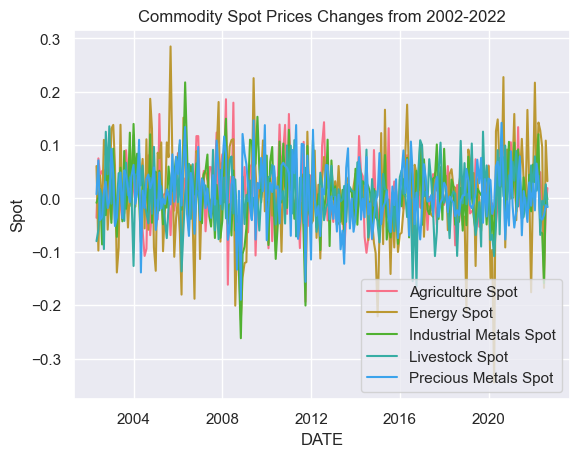

In [193]:
sns.set_theme()
sns.set_palette("husl")
for col in spot.columns[1:6]:
    ax = sns.lineplot(x=spot['DATE'], y=spot[col], dashes=False, label=col)
ax.set_title("Commodity Spot Prices Changes from 2002-2022")
ax.set_ylabel("Spot")

Text(0, 0.5, 'Future')

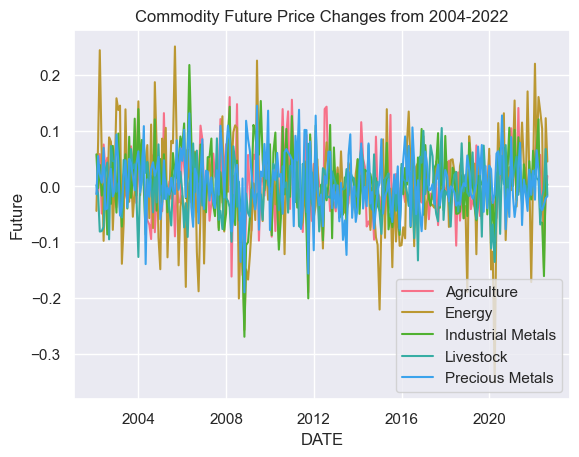

In [190]:
sns.set_theme()
sns.set_palette("husl")
for col in futures.columns[1:6]:
    ax = sns.lineplot(x=futures['DATE'], y=futures[col], dashes=False, label=col)
ax.set_title("Commodity Future Price Changes from 2004-2022")
ax.set_ylabel("Future")

In [191]:
# Predict 3 months into the future
predictors = predictors[:-3]
futures = futures[:-3]
spot = spot[3:]

22:29:10 - cmdstanpy - INFO - Chain [1] start processing
22:29:10 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 0.05645220548294667
Test RMSE: 0.07751811445129769
Train R2: 0.11754131426027525
Test R2: -1.0933719938080966


,ds,yhat_lower,yhat_upper,yhat,actual
0,2002-04-30,-0.047253,0.096406,0.030919,-0.036229
1,2002-05-31,-0.055407,0.087271,0.014027,0.075086
2,2002-06-28,-0.063609,0.090492,0.011661,0.043346
3,2002-07-31,-0.057238,0.083167,0.012437,0.051389
4,2002-08-30,-0.048746,0.087050,0.017281,0.053081
...,...,...,...,...,...
240,2022-04-01,-0.160515,-0.021622,-0.089670,0.049304
241,2022-05-01,-0.128058,0.018357,-0.054369,-0.020143
242,2022-06-01,-0.121405,0.021583,-0.050088,-0.133687
243,2022-07-01,-0.132509,0.009944,-0.058079,-0.022205


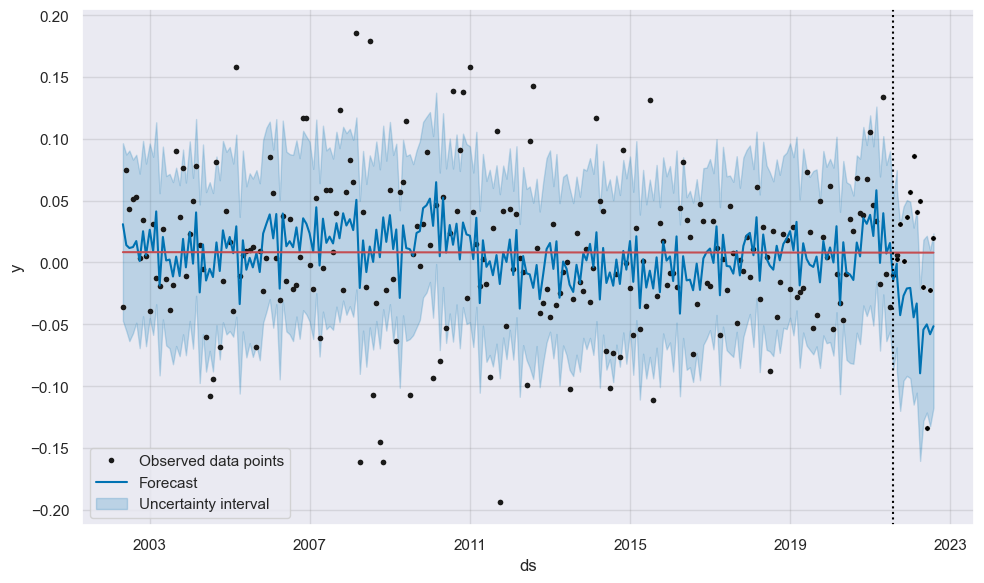

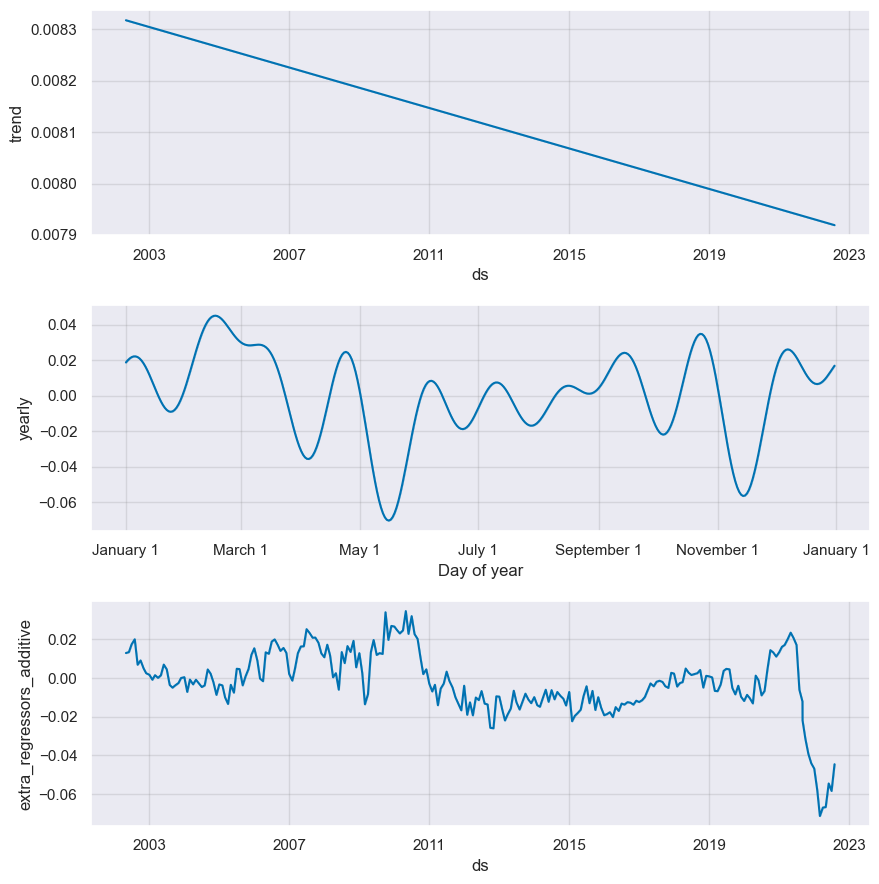

In [206]:
forecast = TSProphet('Agriculture Spot', 'Agriculture')
forecast[['ds', 'yhat_lower', 'yhat_upper', 'yhat', 'actual']]

22:30:23 - cmdstanpy - INFO - Chain [1] start processing
22:30:23 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 0.08102245303835391
Test RMSE: 0.12751130846085823
Train R2: 0.10632236302781972
Test R2: -0.20389892326679826


,ds,yhat_lower,yhat_upper,yhat,actual
0,2002-04-30,-0.046504,0.163882,0.061986,0.060749
1,2002-05-31,-0.096215,0.097285,0.002115,-0.097541
2,2002-06-28,-0.097771,0.121039,0.010642,0.042662
3,2002-07-31,-0.106066,0.108105,0.006882,-0.023532
4,2002-08-30,-0.076834,0.126852,0.021902,0.109832
...,...,...,...,...,...
240,2022-04-01,-0.162990,0.050162,-0.060739,0.127528
241,2022-05-01,-0.076434,0.128356,0.025795,0.096899
242,2022-06-01,-0.177624,0.034538,-0.063123,-0.167460
243,2022-07-01,-0.098981,0.102995,0.007505,0.108397


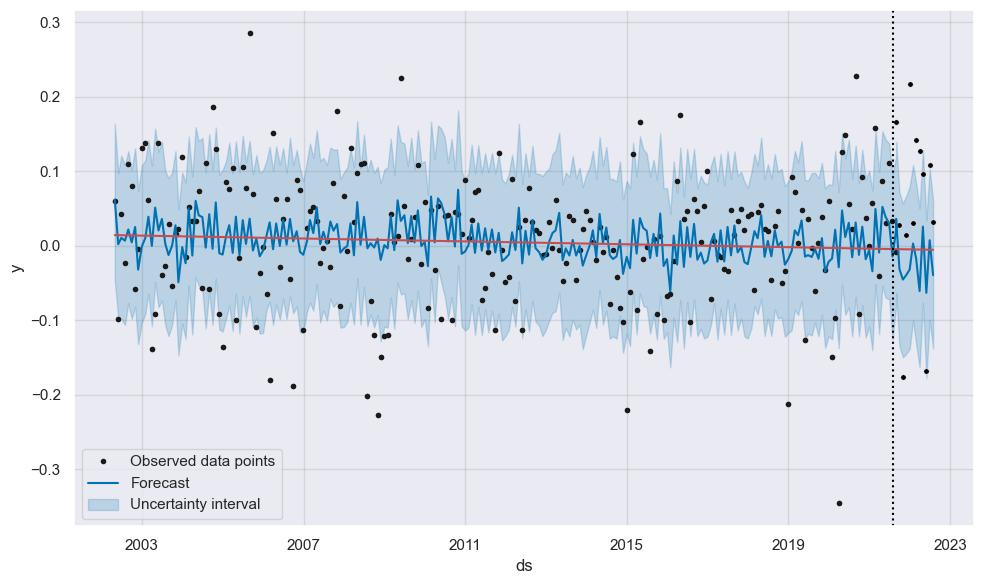

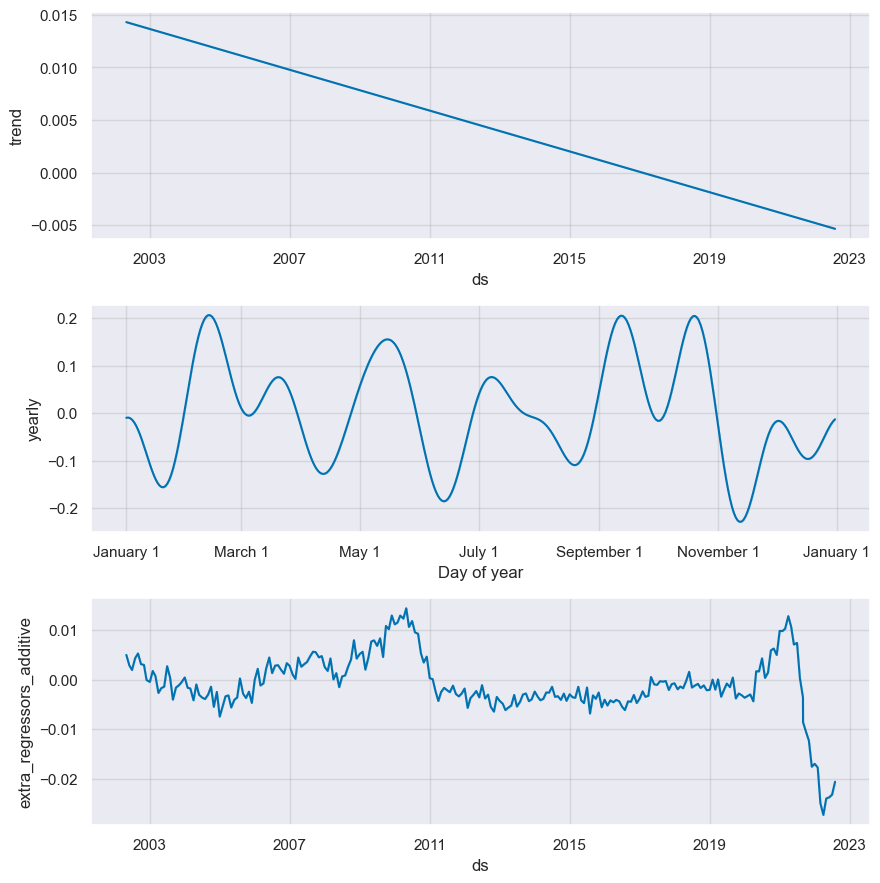

In [207]:
forecast = TSProphet('Energy Spot', 'Energy')
forecast[['ds', 'yhat_lower', 'yhat_upper', 'yhat', 'actual']]

22:31:05 - cmdstanpy - INFO - Chain [1] start processing
22:31:05 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 0.051905656534421064
Test RMSE: 0.05158380616304446
Train R2: 0.16429096357118012
Test R2: -1.3891942529384331


,ds,yhat_lower,yhat_upper,yhat,actual
0,2002-04-30,-0.062442,0.072655,0.010205,0.007877
1,2002-05-31,-0.072848,0.062869,-0.007075,0.071502
2,2002-06-28,-0.116031,0.012246,-0.052513,-0.040344
3,2002-07-31,-0.032800,0.107149,0.033554,-0.034461
4,2002-08-30,-0.052724,0.090781,0.017285,0.013609
...,...,...,...,...,...
240,2022-04-01,-0.120430,0.020777,-0.051180,-0.036434
241,2022-05-01,-0.147426,-0.010095,-0.082555,-0.039567
242,2022-06-01,-0.172850,-0.038369,-0.102545,-0.031306
243,2022-07-01,-0.079785,0.060471,-0.012752,-0.012660


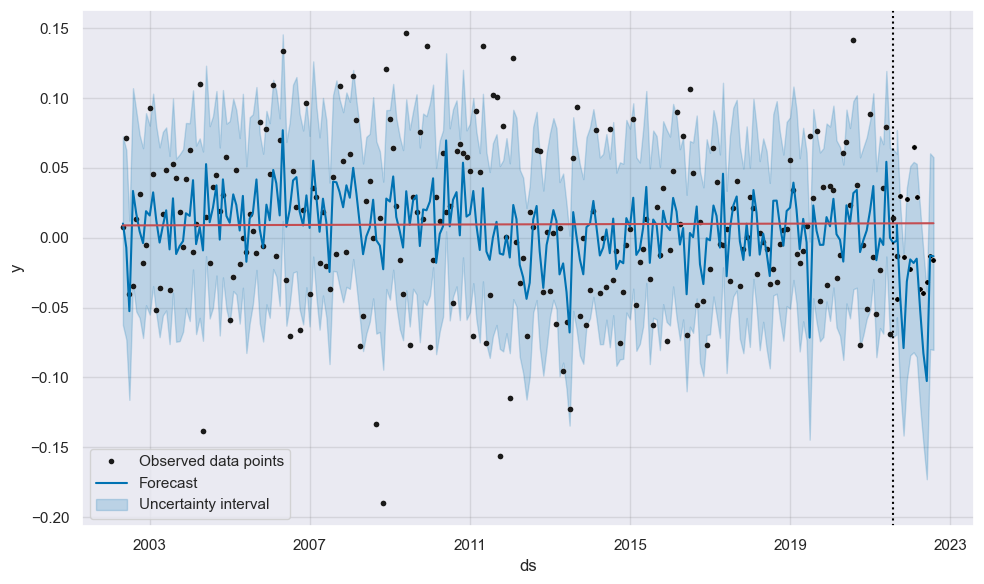

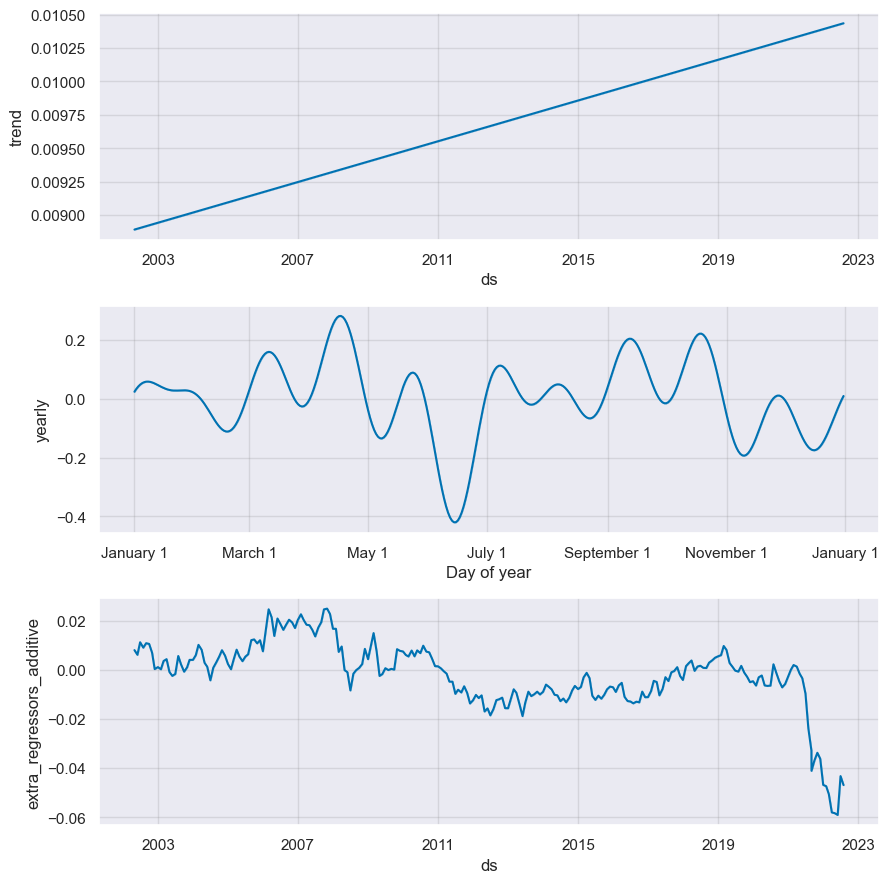

In [208]:
forecast = TSProphet('Precious Metals Spot', 'Precious Metals')
forecast[['ds', 'yhat_lower', 'yhat_upper', 'yhat', 'actual']]